In [117]:
import tensorflow as tf
import numpy as np
import healpy as hp

from DeepSphere import healpy_networks as hp_nn
from DeepSphere import gnn_layers
import matplotlib.pyplot as plt

NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

all_ipix = list(range(NPIX))
hp_map = np.arange(NPIX)

hp_map_nest = hp.reorder(hp_map, r2n=True)
print(np.shape(hp_map_nest))


# define some layers (can be mixed with normal tf layers)
# define only one output layer --> only want the mean !?
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4),
          gnn_layers.HealpyPool(p=1),
          hp_nn.HealpyChebyshev5(K=5, Fout=8),
          gnn_layers.HealpyPseudoConv(p=2, Fout=16),
          hp_nn.HealpyMonomial(K=5, Fout=32),
          hp_nn.Healpy_ResidualLayer("CHEBY", layer_kwargs={"K": 5}),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

 # build a model
tf.keras.backend.clear_session()
indices = np.arange(NPIX)
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices, layers=layers)

(12288,)
Detected a reduction factor of 16, the input with nside 32 will be reduced to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [118]:
# we build the model
# unlike most CNN achitectures you MUST supply in the batch dimension here
model.build(input_shape=(1, len(indices), 1))
#model.summary(line_length=100)

inp = np.random.normal(loc=12, size=(1, len(indices), 1)).astype(np.float32)
out = model(inp)


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
              loss='mean_absolute_error')


train_data = []
train_labels = []
for i in range(20000):
    mean = np.random.rand()
    train_labels.append(mean)
    train_data.append(np.random.normal(loc=mean, size=(len(indices), 1)).astype(np.float32))
train_data = np.asarray(train_data)
train_labels = np.asarray(train_labels)


model.fit(train_data, train_labels, epochs=4, validation_split=0.2)

Epoch 1/4
500/500 [==============================] - 9s 18ms/step - loss: 0.3011 - val_loss: 0.0499
Epoch 2/4
500/500 [==============================] - 10s 20ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 3/4
500/500 [==============================] - 10s 19ms/step - loss: 0.0228 - val_loss: 0.0340
Epoch 4/4
500/500 [==============================] - 9s 19ms/step - loss: 0.0257 - val_loss: 0.0229


In [119]:
for i in range(10):
    mean= np.random.rand()
    predictions = model(np.random.normal(loc=mean, size=(1, len(indices), 1)))
    print("Model predicted %f, true label is %s" % (predictions, mean))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model predicted 0.495092, true label is 0.4840984282726378
Model predicted 0.533846, true label is 0.5448425919440739
Model predicted 0.252379, true label is 0.22044073433831857
Model predicted 0.916061, true label is 0.9464558274573321
Model predicted 0.479513, true label is 0.4745289135488212
Model predicted 0.367424, true label is 0.3640171075685362
Model predicted 0.498825, true label is 0.4965446308526166
Model predicted 0.395264, true label is 0.40735332213720465
Model predicted 0.599772, true lab

# Now we'll try to implement custom training:

In [120]:
# Redefine the model
layers = [gnn_layers.HealpyPseudoConv(p=1, Fout=4),
          gnn_layers.HealpyPool(p=1),
          hp_nn.HealpyChebyshev5(K=5, Fout=8),
          gnn_layers.HealpyPseudoConv(p=2, Fout=16),
          hp_nn.HealpyMonomial(K=5, Fout=32),
          hp_nn.Healpy_ResidualLayer("CHEBY", layer_kwargs={"K": 5}),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1)]

 # build a model
tf.keras.backend.clear_session()
indices = np.arange(NPIX)
model = hp_nn.HealpyGCNN(nside=NSIDE, indices=indices, layers=layers)

model.build(input_shape=(1, len(indices), 1))

Detected a reduction factor of 16, the input with nside 32 will be reduced to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...


In [132]:
# Define the loss and gradient function

# Again we will use the MeanAbsoluteError()
loss_object = tf.keras.losses.MeanAbsoluteError()


def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    
    return loss_object(y_true=y, y_pred=y_)

# Test the loss function
mean = np.random.rand()
labels = mean
data = np.random.normal(loc=mean, size=(1, len(indices), 1)).astype(np.float32)

l = loss(model, data, labels, training=False)
#print("Loss test: {}".format(l))

Loss test: 0.4745839238166809


In [176]:
# Use the tf.GradientTape contex to calculate the gradients used
# to optimize the model.
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Setup the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Use this to calculate one single optimization step:

loss_value, grads = grad(model, data, labels)

'''print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, data, labels,
                                               training=True).numpy()))'''

Step: 0, Initial Loss: 3.67356538772583
Step: 1,         Loss: 9.91933822631836


In [177]:
# Build a training loop
# We want to generate the data on the fly.

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 80

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    # Training loop - use batches of 500
    # Generate the data on the fly
    for i in range(32):
        mean = np.random.rand()
        train_label = mean
        train_data = np.random.normal(loc=mean,
                                      size=(1, len(indices), 1)).astype(np.float32)
        
        # Optimize the model
        loss_value, grads = grad(model, train_data, train_label)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Track progress
        epoch_loss_avg.update_state(loss_value) # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(train_label, model(train_data, training=True))
        
        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

Epoch 000: Loss: 1.689
Epoch 004: Loss: 0.244
Epoch 008: Loss: 0.157
Epoch 012: Loss: 0.195
Epoch 016: Loss: 0.124
Epoch 020: Loss: 0.137
Epoch 024: Loss: 0.116
Epoch 028: Loss: 0.108
Epoch 032: Loss: 0.214
Epoch 036: Loss: 0.202
Epoch 040: Loss: 0.128
Epoch 044: Loss: 0.069
Epoch 048: Loss: 0.087
Epoch 052: Loss: 0.108
Epoch 056: Loss: 0.037
Epoch 060: Loss: 0.109
Epoch 064: Loss: 0.116
Epoch 068: Loss: 0.067
Epoch 072: Loss: 0.056
Epoch 076: Loss: 0.069


In [181]:
for i in range(10):
    mean = np.random.rand()
    label = mean
    data = np.random.normal(loc=mean, 
                            size=(1, len(indices), 1)).astype(np.float32)
    predictions = model(data)
    print("Model predicted %f, true label is %s" % (predictions, mean))

Model predicted 0.500668, true label is 0.49593035265186136
Model predicted 0.461828, true label is 0.4492299283898914
Model predicted 0.187217, true label is 0.2310057791486534
Model predicted 0.381821, true label is 0.37286753836037223
Model predicted 0.893433, true label is 0.8357651013747519
Model predicted -0.056420, true label is 0.008475265357443917
Model predicted 0.026300, true label is 0.07983285915162808
Model predicted 0.063812, true label is 0.13180240491726603
Model predicted 1.095965, true label is 0.9619843793222047
Model predicted 0.692374, true label is 0.6746442286125056


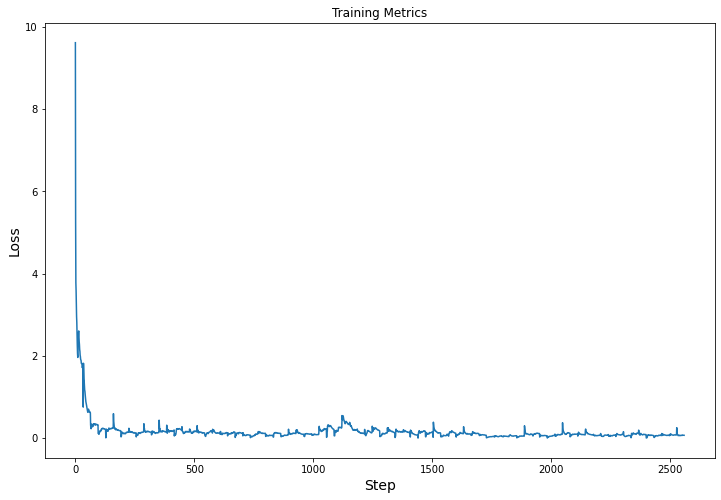

In [194]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Step", fontsize=14)
plt.show()
